In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [45]:
all_files = glob.glob("../roll_data/*-weatherproc.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14, 15]
df = df[df['season'].isin(seasons)]
len(df)

272727

In [46]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]

coffee_events = ("Bean", "NoBean")
coffee2_events = ("Refill", "NoRefill")
flooding_events = ("Swept", "NoSweep")
reverb_events = ("Shuffle", "NoShuffle")
bloodrain_events = ("Drain", "Siphon") # NOTE: FAILURES ARE SIPHON EVENTS ONLY
feedback_events = ("Swap", "NoSwap")
peanut_events = ("Allergy", "NoAllergy")
salmon_events = ("Salmon", "NoSalmon")

include_events = salmon_events

dfc = dfc[dfc["event_type"].astype(str).isin(include_events)]

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


X = dfc[["roll", "ballpark_fortification"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=500000, max_iter=5000000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[40,  0],
       [ 0,  6]], dtype=int64)

In [48]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'), (0.0020935610124519334, 'ballpark_fortification')]

In [49]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.00121929])

In [50]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

40
6


In [51]:

dfc["threshold"] = 0.026

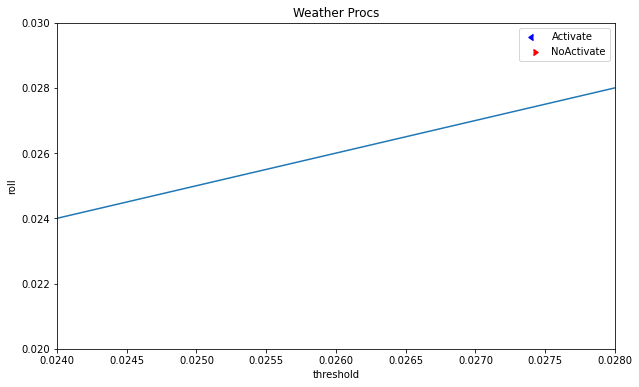

In [52]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Activate", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoActivate", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Weather Procs")
ax.set_xlim([0.024, 0.028])
ax.set_ylim([0.02, 0.03])
ax.legend()

,offset,weather,event_type,season,roll,threshold,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
109703,-0.025943,Weather.BLOODDRAIN,Siphon,13,0.000057,0.026,Summers Preston,Liam Snail,<NA>,<NA>,<NA>,LIFE_OF_PARTY;ELECTRIC,35,d8e6d2a7-ec47-49ae-8bcb-442ec3e08575,244
6447,-0.025791,Weather.BLOODDRAIN,Siphon,11,0.000209,0.026,Sam Scandal,Chambers Simmons,<NA>,<NA>,<NA>,GROWTH,49,fd26b8b2-2cfe-4f8e-9143-695133ae4c1c,301
35689,-0.025670,Weather.BLOODDRAIN,Siphon,12,0.000330,0.026,Ayanna Dumpington,Marco Escobar,<NA>,<NA>,<NA>,<NA>,7,51e11542-ac11-4605-afbc-b418461dd6b1,137
59700,-0.025662,Weather.BLOODDRAIN,Siphon,12,0.000338,0.026,Igneus Delacruz,Yummy Elliott,ALTERNATE,<NA>,BASE_INSTINCTS,<NA>,55,a6332d2b-42a0-4d4b-8781-c270b8a438fe,41
1491,-0.025529,Weather.BLOODDRAIN,Siphon,11,0.000471,0.026,Mcdowell Mason,Dunlap Figueroa,<NA>,<NA>,<NA>,SEALANT;FIREPROOF,34,1a71ac6b-e03f-476c-82d7-3e8d58797cef,243
54637,-0.025501,Weather.BLOODDRAIN,Siphon,12,0.000499,0.026,Gloria Bugsnax,Rivers Clembons,<NA>,ALTERNATE,GROWTH,LIFE_OF_PARTY;ELECTRIC,45,0dea9096-3cf7-44d2-983f-37ff29171ca0,267
54947,-0.025459,Weather.BLOODDRAIN,Siphon,12,0.000541,0.026,Avila Guzman,Zeboriah Wilson,<NA>,<NA>,LIFE_OF_PARTY;ELECTRIC,GROWTH,46,8c867837-f599-46e7-8533-a5f098a37d00,133
67539,-0.025420,Weather.BLOODDRAIN,Siphon,12,0.000580,0.026,Elijah Valenzuela,Sosa Hayes,PERK;SCATTERED,<NA>,EXTRA_STRIKE,<NA>,71,b3436fc8-0876-4cd2-8605-333360d53344,5
10777,-0.025381,Weather.BLOODDRAIN,Siphon,11,0.000619,0.026,Lang Richardson,Yosh Carpenter,<NA>,<NA>,AFFINITY_FOR_CROWS,LOVE,60,2d9b2fcb-2895-40f0-a9c1-1258be3ad825,48
10685,-0.025324,Weather.BLOODDRAIN,Siphon,11,0.000676,0.026,Lenny Spruce,Snyder Briggs,<NA>,ALTERNATE;WILD,<NA>,TRAVELING,59,227087e0-4eb4-4983-8290-7cb1ac18a070,80


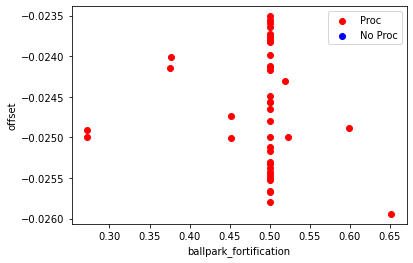

In [53]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_fortification"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Proc")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="No Proc")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "season",
       "roll", "threshold",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [51]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.02532661704696237
0.026462907893175517
